In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

In [3]:
df = pd.read_csv("01_USDJPY_D.csv", encoding="SHIFT-JIS",sep = ",")

In [4]:
df.sort_index(ascending=False,inplace=True)
df.drop(["通貨ペア"],axis=1,inplace=True)

In [5]:
df.head(10)
df.dtypes

日付     object
始値    float64
高値    float64
安値    float64
終値    float64
dtype: object

In [5]:
df_shift = df.copy()

In [6]:
df_shift.reset_index(drop=True,inplace=True)
df_shift.head()

,日付,始値,高値,安値,終値
0,2018/10/04,114.441,114.549,113.632,113.939
1,2018/10/05,113.893,114.100,113.558,113.671
2,2018/10/08,113.729,113.943,112.821,113.221
3,2018/10/09,113.183,113.392,112.870,112.950
4,2018/10/10,112.950,113.286,112.292,112.304


In [7]:
df_shift.終値 = df_shift.終値.shift(-1)

In [8]:
df_shift.tail()

,日付,始値,高値,安値,終値
195,2019/07/05,107.783,108.636,107.767,108.729
196,2019/07/08,108.410,108.806,108.279,108.856
197,2019/07/09,108.683,108.963,108.660,108.466
198,2019/07/10,108.814,108.989,108.347,108.491
199,2019/07/11,108.396,108.533,107.858,NaN


In [9]:
df_shift = df_shift[:-1].copy()

In [10]:
del df_shift["日付"]

In [11]:
df2 = df_shift.copy()
df2.head()

,始値,高値,安値,終値
0,114.441,114.549,113.632,113.671
1,113.893,114.100,113.558,113.221
2,113.729,113.943,112.821,112.950
3,113.183,113.392,112.870,112.304
4,112.950,113.286,112.292,112.123


## トレーニングデータとテストデータに分割

In [12]:
train_start = 0
train_end = int(np.floor(df2.shape[0]*0.8))
test_start = train_end + 1
test_end = int(df2.shape[0])

In [13]:
data_train = df2.loc[np.arange(train_start, train_end), :]
data_test = df2.loc[np.arange(test_start, test_end), :]

In [14]:
data_train.head()

,始値,高値,安値,終値
0,114.441,114.549,113.632,113.671
1,113.893,114.100,113.558,113.221
2,113.729,113.943,112.821,112.950
3,113.183,113.392,112.870,112.304
4,112.950,113.286,112.292,112.123


In [15]:
#データを最少-1,最大1で正規化
scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
#配列data_trainの平均と分散を記憶
scaler.fit(data_train)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [17]:
#data_trainを変換
data_train_norm = scaler.transform(data_train)

In [18]:
data_test_norm = scaler.transform(data_test)

In [19]:
#X_train:材料データの配列(行は全部、列は1~)
#Y_train:予測したいデータ配列(行は全部、列は0)
X_train = data_train_norm[:, 1:]
y_train = data_train_norm[:, 0]

In [20]:
#テストデータも同様に
X_test = data_test_norm[:, 1:]
y_test = data_test_norm[:, 0]

## Tensorflowで学習させる

In [21]:
#tensorflowインスタンスの生成
net = tf.InteractiveSession()

In [22]:
#トレーニングデータの列数
n_stocks = X_train.shape[1]
 
# ニューロンの数を設定
n_neurons_1 = 256
n_neurons_2 = 128
  
# プレースホルダーの作成（データ格納予定地的な）
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])
 
# 初期化
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [23]:
#重み、バイアスのオブジェクト(?)を生成
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

In [24]:
#同様に出力の重みも,
W_out = tf.Variable(weight_initializer([n_neurons_2, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [25]:
# 隠れ層の設定（ReLU＝活性化関数）
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
 
# 出力層の設定
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))

In [48]:
#コスト関数
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# 最適化関数
opt = tf.train.AdamOptimizer().minimize(mse)
 
summary_writer = tf.summary.FileWriter("./log_fx" , net.graph)
    
# 初期化
net.run(tf.global_variables_initializer())



In [50]:
# ニューラルネットワークの設定
batch_size = 128
mse_train = []
mse_test = []
 
# 訓練開始！500回の反復処理
epochs = 5000
for e in range(epochs):
    net.run(opt, feed_dict={X: X_train, Y: y_train})
    loss_val = net.run(mse,feed_dict={X: X_train,Y:y_train})
    #summary_writer.add_summary(loss_val,i)
    print("Step: %d, Loss: %f" % (e,loss_val))

Step: 0, Loss: 0.168362
Step: 1, Loss: 0.115805
Step: 2, Loss: 0.074976
Step: 3, Loss: 0.045114
Step: 4, Loss: 0.025396
Step: 5, Loss: 0.014181
Step: 6, Loss: 0.010129
Step: 7, Loss: 0.011360
Step: 8, Loss: 0.015579
Step: 9, Loss: 0.020043
Step: 10, Loss: 0.022738
Step: 11, Loss: 0.022964
Step: 12, Loss: 0.020977
Step: 13, Loss: 0.017553
Step: 14, Loss: 0.013666
Step: 15, Loss: 0.010125
Step: 16, Loss: 0.007535
Step: 17, Loss: 0.006219
Step: 18, Loss: 0.006227
Step: 19, Loss: 0.007081
Step: 20, Loss: 0.008017
Step: 21, Loss: 0.008560
Step: 22, Loss: 0.008565
Step: 23, Loss: 0.008137
Step: 24, Loss: 0.007496
Step: 25, Loss: 0.006862
Step: 26, Loss: 0.006323
Step: 27, Loss: 0.005908
Step: 28, Loss: 0.005616
Step: 29, Loss: 0.005411
Step: 30, Loss: 0.005234
Step: 31, Loss: 0.005037
Step: 32, Loss: 0.004820
Step: 33, Loss: 0.004612
Step: 34, Loss: 0.004451
Step: 35, Loss: 0.004360
Step: 36, Loss: 0.004327
Step: 37, Loss: 0.004320
Step: 38, Loss: 0.004295
Step: 39, Loss: 0.004217
Step: 40, 

In [39]:
pred_test = net.run(out, feed_dict={X: X_test})
 
# 予測データの最初の2つを表示
pred_test[0][0:2]

array([-0.38498566, -0.34150997], dtype=float32)

In [40]:
# 予測値をテストデータに戻そう（値も正規化からインバース）
pred_test = np.concatenate((pred_test.T, X_test), axis=1)
pred_inv = scaler.inverse_transform(pred_test)


In [41]:
# 元データの最後尾
df_shift.tail(1)

,始値,高値,安値,終値
198,108.814,108.989,108.347,108.491


In [42]:
pred_inv

array([[109.75628602, 110.189     , 109.493     , 110.045     ],
       [109.90334253, 110.318     , 109.809     , 110.471     ],
       [109.90466471, 110.671     , 110.009     , 110.346     ],
       [110.31747409, 110.626     , 110.24      , 109.588     ],
       [110.17546768, 110.364     , 109.457     , 109.291     ],
       [109.551759  , 109.745     , 109.273     , 109.537     ],
       [109.55844659, 109.584     , 109.253     , 109.349     ],
       [109.65373773, 109.628     , 109.21      , 109.587     ],
       [109.63572525, 109.698     , 109.148     , 109.617     ],
       [109.36761956, 109.927     , 109.474     , 108.346     ],
       [109.59649525, 109.608     , 108.337     , 108.061     ],
       [108.31488125, 108.446     , 107.882     , 108.135     ],
       [108.48193472, 108.358     , 107.845     , 108.454     ],
       [108.39751504, 108.485     , 107.812     , 108.389     ],
       [108.36823402, 108.562     , 108.023     , 108.176     ],
       [108.40367088, 108

In [43]:
y_test = y_test.reshape(39, 1)
test_inv = np.concatenate((y_test, X_test), axis=1)

test_inv = scaler.inverse_transform(test_inv)

# テストデータの最後のデータ（正規化前）
print(data_test.values[9])
 
# テストデータの最後のデータ（正規化を戻した後）
print(test_inv[9])
 
# モデルが予測したデータ
print(pred_inv[9])

[109.53  109.927 109.474 108.346]
[109.53  109.927 109.474 108.346]
[109.36761956 109.927      109.474      108.346     ]


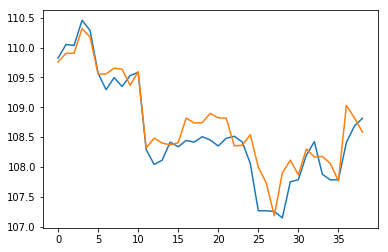

In [44]:
# 予測と実際のテストの終値のチャートをプロットしてみよう
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(test_inv[:,0])
line2, = ax1.plot(pred_inv[:,0])
plt.show()

In [45]:
mae_test = mean_absolute_error(test_inv, pred_inv)
print(mae_test)

0.061897771146817146


In [35]:
test_inv[:,0]

array([109.823, 110.051, 110.034, 110.457, 110.285, 109.569, 109.293,
       109.495, 109.347, 109.53 , 109.584, 108.29 , 108.04 , 108.111,
       108.414, 108.336, 108.443, 108.414, 108.505, 108.45 , 108.35 ,
       108.479, 108.512, 108.417, 108.057, 107.264, 107.263, 107.253,
       107.144, 107.749, 107.784, 108.196, 108.421, 107.875, 107.781,
       107.783, 108.41 , 108.683, 108.814])

In [36]:
pred_inv[:,0]

array([109.78601482, 109.99021362, 110.24950022, 110.47570716,
       110.06320528, 109.55870516, 109.48472489, 109.4968773 ,
       109.46307854, 109.7840499 , 109.32335065, 108.23236177,
       108.16078301, 108.17430698, 108.35050137, 108.25876961,
       108.60971766, 108.6459398 , 108.50153833, 108.46875005,
       108.47431698, 108.69343693, 108.39500415, 108.34536106,
       107.82936699, 107.48723324, 107.51302798, 107.03290384,
       107.45335344, 107.9932005 , 107.77116805, 108.34627839,
       108.16045579, 107.85042443, 107.87965545, 108.10683548,
       108.60770758, 108.85259868, 108.68275368])